In [1]:
import pandas as pd
import csv
import nltk
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
import keras
import tensorflow as tf
from keras import Input
from keras import optimizers
from keras import backend as K
import torch
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import train_test_split

In [2]:
#OPEN DATA from pickle files
#x_train, x_test, y_train, y_test

with open('x_train.pkl', 'rb') as file:
    x_train = pickle.load(file)
    
with open('x_test.pkl', 'rb') as file:
    x_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('tweet_collection.pkl', 'rb') as file:
    tweet_collection = pickle.load(file)

In [3]:
print(len(x_train))

4096


In [4]:
#Convert Labels from Strings to categorical Integers {Non-Hate = 1, Hate = 0}

df_ytrain = pd.DataFrame(y_train, columns = ['Label'])
df_ytest = pd.DataFrame(y_test, columns = ['Label'])

#flatten training set for fitting on tfidf
x_train_fit = list(chain.from_iterable(x_train))

mapping = {'Non-hate': 0, 'Hate': 1}
df_ytrain = df_ytrain.replace({'Label': mapping})
df_ytest = df_ytest.replace({'Label': mapping})

train_y = df_ytrain['Label'].tolist()
test_y = df_ytest['Label'].tolist()

np_train_y = np.asarray(train_y)
np_test_y = np.asarray(test_y)

In [5]:
print(np_train_y.shape)

(4096,)


In [6]:
#Testing Encoding and Actual Values
for i in range(10):
    print("Sentence\n: "," ".join(str(item) for item in x_test[i]),"\n","True Value: ", y_test[i], "\nConverted: ",test_y[i],"\n~~~~~~~~~~~\n",sep="")

Sentence
: gang dear let remind ocho derecho also make realize bam help talo si pangit strategy poor product reality bites kayo
True Value: Hate
Converted: 1
~~~~~~~~~~~

Sentence
: gobyernong tapat angat buhay presidente bise-presidente kiko pangilinan
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: okay ara sakyan du vibes namon asked president coming election answered said loser"and started discussing ping's work past
True Value: Hate
Converted: 1
~~~~~~~~~~~

Sentence
: president cutie
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: president malakas daw nag mudmod pera laki babawiin team bbm sara di tanga tao lumang istyle
True Value: Hate
Converted: 1
~~~~~~~~~~~

Sentence
: like vp ideas silang magagandang layunin ever manalo si vp want sen.lacson one cabinets prefer sec.of national defense
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: naman talaga aayusin iyan tignan naman kakampi dating pangulo kaso katiwalian totoo ngang matagal mamatay masasam

In [7]:
#TFIDF, classifer building using the training dataset of tweets using a maximum features of the top 40%

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

#classifier building/ fitting of training dataset to tfidf
fitted_training_x = tfidf.fit_transform(x_train)
fitted_testing_x = tfidf.transform(x_test)

#transform based on top 40 percent features
selector = SelectPercentile(f_classif, percentile = 40)
selector.fit(fitted_training_x, train_y)

SelectPercentile(percentile=40)

In [8]:
#Convert tweet tokens into vectors using the classifier built using tfidf

x_train_vectorized = selector.transform(fitted_training_x).toarray()
x_test_vectorized = selector.transform(fitted_testing_x).toarray()

number_of_features = len(x_train_vectorized[0])
print(number_of_features)

4587


In [21]:
#FFNN MODEL
print("training CNN ...")

#create model
model = Sequential()
model.add(Input(shape=(number_of_features,), name='Input-Layer'))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#optimizer using the default values
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              4588000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                25050     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 2

In [22]:
#fit dataset and model
##### Step 5 - Fit keras model on the dataset
model_history = model.fit(x_train_vectorized, # input data
          np_train_y, # target data
          epochs=5, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
          verbose='auto',
          validation_split = 0.1
         )

model.save('cabasag_model.h5')

Epoch 1/5
116/116 [==============================] - 3s 21ms/step - loss: 0.5040 - accuracy: 0.7355 - val_loss: 0.3115 - val_accuracy: 0.8659
Epoch 2/5
116/116 [==============================] - 2s 20ms/step - loss: 0.2104 - accuracy: 0.9238 - val_loss: 0.2864 - val_accuracy: 0.8732
Epoch 3/5
116/116 [==============================] - 2s 20ms/step - loss: 0.1087 - accuracy: 0.9582 - val_loss: 0.3344 - val_accuracy: 0.8780
Epoch 4/5
116/116 [==============================] - 2s 21ms/step - loss: 0.0719 - accuracy: 0.9740 - val_loss: 0.3388 - val_accuracy: 0.8976
Epoch 5/5
116/116 [==============================] - 2s 20ms/step - loss: 0.0572 - accuracy: 0.9786 - val_loss: 0.3798 - val_accuracy: 0.8829


In [23]:
#test for accuracies

results_training = model.evaluate(x_train_vectorized, np_train_y)
print(results_training)

128/128 [==============================] - 1s 5ms/step - loss: 0.0688 - accuracy: 0.9749
[0.0688091516494751, 0.974853515625]


In [24]:
#test for accuracies

results_testing = model.evaluate(x_test_vectorized, np_test_y)
print(results_testing)

32/32 [==============================] - 0s 5ms/step - loss: 0.7596 - accuracy: 0.8037
[0.7595877051353455, 0.8037109375]


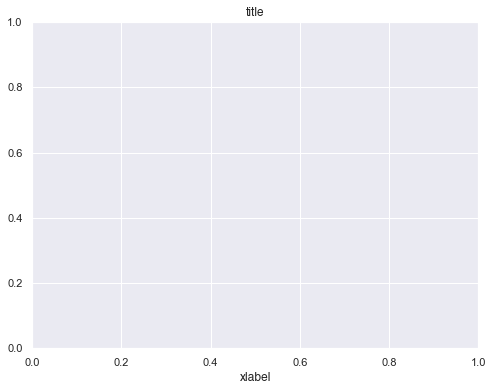

In [25]:
#plot configuration
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Amber]

csfont = {'fontname':'Helvetica'}
hfont = {'fontname':'Helvetica'}

plt.title('title',**csfont)
plt.xlabel('xlabel', **hfont)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

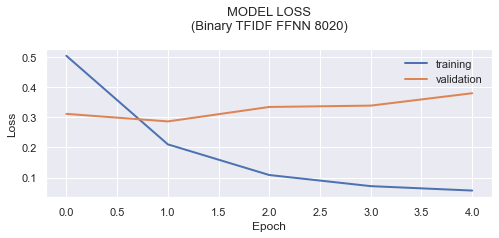

In [32]:
# plot loss during training
plt.subplot(212)
plt.title('MODEL LOSS\n(Binary TFIDF FFNN 8020)\n', fontsize = 13)
plt.plot(model_history.history['loss'], label='training', linewidth=2)
plt.plot(model_history.history['val_loss'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

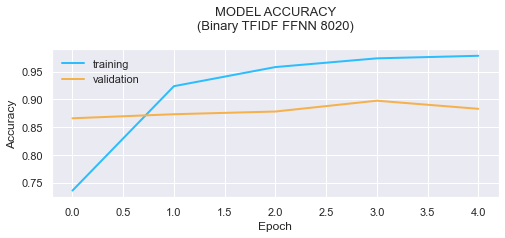

In [27]:
# plot accuracy during training
plt.subplot(212)
plt.title('MODEL ACCURACY\n(Binary TFIDF FFNN 8020)\n', fontsize = 13)
plt.plot(model_history.history['accuracy'], label='training', linewidth=2)
plt.plot(model_history.history['val_accuracy'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [28]:
#use predictions on test data
##### Step 6 - Use model to make predictions
# Predict class labels on training data
#pred_labels_train = (model.predict(x_train_vectorized) > 0.5).astype(int)
pred_labels_train = model.predict(x_train_vectorized)
# Predict class labels on a test data
#pred_labels_test = (model.predict(x_test_vectorized) > 0.5).astype(int)
pred_labels_test = model.predict(x_test_vectorized)

pred_labels_train_1 = []

pred_labels_test_1 = []

pred_labels_test_y = []

for i in range(len(pred_labels_train)):
    label = np.argmax(pred_labels_train[i])
    pred_labels_train_1.append(label)
    
for i in range(len(pred_labels_test)):
    label = np.argmax(pred_labels_test[i]) 
    pred_labels_test_1.append(label)
    pred_labels_test_y.append(pred_labels_test[i][label])
    
##### Step 7 - Model Performance Summary
print("")
print('-------------------- Model Summary --------------------\n')
model.summary() # print model summary
print("")
print('\n---------- Evaluation on Training Data ----------')
print(classification_report(np_train_y, pred_labels_train_1, digits=4))
print("")

print('\n---------- Evaluation on Test Data ----------')
print(classification_report(np_test_y, pred_labels_test_1, digits=4))
print("")

32/32 [==============================] - 0s 5ms/step

-------------------- Model Summary --------------------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              4588000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                25050     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
         

[[412 110]
 [ 91 411]]


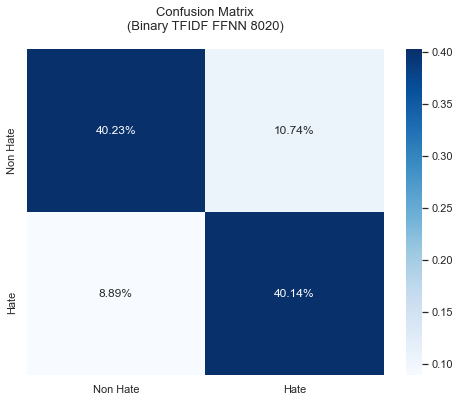

In [29]:
cf_matrix = confusion_matrix(np_test_y, pred_labels_test_1)
print(cf_matrix)
sns.set(rc={"figure.figsize":(8, 6)})
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels = ['Non Hate', 'Hate'], yticklabels = ['Non Hate', 'Hate'],
            fmt='.2%', cmap='Blues')

plt.title('Confusion Matrix\n(Binary TFIDF FFNN 8020)\n', fontsize = 13) # title with fontsize 20
plt.show()

In [30]:
test_results = pd.DataFrame(list(zip(x_test,pred_labels_test_1, pred_labels_test_y)), columns = ['Tweet','Prediction', 'Prediction Value'])
test_results 

,Tweet,Prediction,Prediction Value
0,"[gang, dear, let, remind, ocho, derecho, also,...",1,0.999999
1,"[gobyernong, tapat, angat, buhay, presidente, ...",0,0.999998
2,"[okay, ara, sakyan, du, vibes, namon, asked, p...",1,0.931061
3,"[president, cutie]",0,0.999998
4,"[president, malakas, daw, nag, mudmod, pera, l...",1,0.999999
...,...,...,...
1019,"[president, vice, president, kiko, pangilinan]",0,0.990039
1020,"[sir, today]",0,0.794478
1021,"[marcosjr, duwag, ayaw, umattend, debate, kaya...",1,1.000000
1022,"[lumalabas, pagka, komunista, sinasagot, bbm, ...",1,0.978872


In [31]:
#Saving labels to be used on other files
true_labels = open('true_labels.pkl', 'wb')
pickle.dump(np_test_y,true_labels)
true_labels.close()

predicted_labels = open('TFIDFFFNN_predicted_labels.pkl', 'wb')
pickle.dump(pred_labels_test_1,predicted_labels)
predicted_labels.close()

TFIDFFFNN_test_results = open('TFIDFFFNN_test_results.pkl', 'wb')
pickle.dump(test_results,TFIDFFFNN_test_results)
TFIDFFFNN_test_results.close()

In [20]:
#test_predictions = (model.predict(x_test_vectorized) > 0.5).astype(int)

#test_prediction_labels = []

#for i in range(len(test_predictions)):
    
#    trueval = 'Non-hate'
    
#    if(test_y[i] == 1):
 #       trueval = 'Hate'
        
#    pred = 'Non-hate'
    
 #   if(test_predictions[i][1] == 1):
 #       pred = 'Hate'
    
  #  test_prediction_labels.append(pred)
  #  print("Sentence\n: "," ".join(str(item) for item in x_test[i]),"\n","True Value: ", trueval, "\nPred: ",pred, "\n~~~~~~~~~~~\n",sep="")

In [ ]:
#comparison_dataframe = pd.DataFrame(list(zip(x_test,y_test, test_prediction_labels)), columns = ['Tweet','True Label', 'Clasiification Label'])  

#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
 #                      'display.precision', 3,
  #                     ):
 #   display(comparison_dataframe)